In [56]:
import os
import re
import base64
from mistralai import Mistral
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

def encode_image(path):
    with open(path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# --- Pré-process : collapse des lignes de continuation ---
def pre_collapse_continuations(text: str) -> str:
    """
    Détecte les lignes de continuation (↳, >, indentation, puces) 
    et les concatène à la ligne précédente.
    """
    lines = []
    for line in text.splitlines():
        stripped = line.strip()
        if not stripped:
            continue
        if stripped.startswith(("↳", ">", "-", "*", "•")):
            if lines:
                lines[-1] += " " + stripped.lstrip("↳> -*•").strip()
            else:
                lines.append(stripped)
        else:
            lines.append(stripped)
    return "\n".join(lines)

# --- Post-process : normalisations déterministes ---
def postprocess_normalized(text: str) -> str:
    # Normalisation espaces
    text = re.sub(r"[ \t]+", " ", text)
    # Heures : "16 h" → "16h"
    text = re.sub(r"(\d{1,2}) ?h", r"\1h", text)
    # Numéros de téléphone : supprime espaces
    text = re.sub(r"\b0\d(?:\s?\d{2}){4}\b", lambda m: m.group(0).replace(" ", ""), text)
    # Normalisation kV (RV → kV si contexte tension)
    text = re.sub(r"(\d+)(?:RV|rv)", r"\1kV", text)
    # Supprime lignes vides
    text = "\n".join(l.strip() for l in text.splitlines() if l.strip())
    # Retire None éventuel
    text = text.replace("None", "").strip()
    return text

def image_transcription(image_path: str) -> str:
    # 1. OCR brut
    base64_image = encode_image(image_path)
    response = client.ocr.process(
        model="mistral-ocr-latest",
        document={
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{base64_image}"
        },
        include_image_base64=True
    )
    ocr_text = response.pages[0].markdown.strip()
    print("=== OCR brut ===\n", ocr_text)
    # 2. Pré-process
    ocr_text = pre_collapse_continuations(ocr_text)
    print("=== OCR pré-processé ===\n", ocr_text)

    # 3. Prompt LLM de normalisation
    prompt = f"""Tu es un assistant de normalisation pour des notes manuscrites RTE.
    Entrée : texte brut d’un OCR (peut contenir du markdown, des puces, des retours ligne erratiques, des erreurs).
    Sortie : texte canonique, stable, prêt pour une comparaison ligne-à-ligne.

    RÈGLES OBLIGATOIRES (déterministes)
    1) Préserve exactement l’ORDRE d’apparition des informations.
    - Ne reclasse pas par thèmes, ne réordonne pas les lignes.
    2) 1 information = 1 ligne.
    - Ne crée PAS de lignes vides.
    - Ne fusionne PAS des lignes éloignées.
    - Traite les lignes de continuation immédiate (ex: débutant par “↳”, “>”, indentation, puce) comme la CONTINUATION de la ligne précédente : dans ce cas, tu concatènes à la ligne précédente en ajoutant un espace (PAS un saut de ligne).
    3) Nettoyage MINIMAL :
    - Supprime les préfixes décoratifs uniquement en DÉBUT de ligne : **, *, -, •, [], >, “## …”, “# …”.
    - Normalise les espaces (un seul espace entre mots).
    - Supprime les guillemets parasites isolés en DÉBUT/FIN de ligne.
    4) Corrections OCR : uniquement si ÉVIDENT dans le contexte technique électrique.
    - Confusions lettres/chiffres : O↔0, I↔1, l↔1, Z↔2, S↔5, B↔8, G↔6, T↔7.
    - Mots proches/faux : rebois→relais, plannig→planning, Maintenace→Maintenance, travau→travaux.
    - Mots collés/séparés : conduitedes→conduite des.
    - Abréviations mal reconnues proches → corrige vers la FORME OFFICIELLE si c’est manifestement ça.
    - Accentuation manquante (é/è) → corrige si non ambigu.
    5) Abréviations officielles (ne PAS développer, garder la forme abrégée ; corrige une variante proche vers la forme officielle) :
    RACR, RDCR, TIR, PO, RSD, SUAV, MNV, PF, CSS, GEH, PDM, SMACC, HO, BR, GT, TST, CCO, FDE, DIFFB, RADA, TR, RA, CTS, CEX, COSE, COSE-P, RTE.
    6) Éléments administratifs peu informatifs (seuls sur leur ligne) : “Note X”, “Vote”, “## Vote”, “### Note” → SUPPRIME la ligne entière si elle n’apporte aucune info liée à l’exploitation (ne pas supprimer si la ligne contient une action/heure/poste/etc.).
    7) Formats déterministes :
    - Fléchage “->” sans espaces autour si déjà correct ; sinon normalise en “ -> ” (avec espaces) pour la lisibilité.
    - Heures : “16 h”, “16h” → normalise en “16h” sans espace.
    - Numéros de téléphone : supprimer les espaces → “0766378217”.
    - Tensions : normaliser en “kV” (ex: 20RV→20kV si clair que c’est kV).
    8) STRICT : ne jamais ajouter de texte comme “None”, pas de commentaires ou d’explications. Ne rien inventer.

    ERREURS OCR TYPIQUES (référence mentale)
    - O↔0, I↔1, l↔1, Z↔2, S↔5, B↔8, G↔6, T↔7
    - rebois→relais, plannig→planning, Maintenace→Maintenance, travau→travaux
    - conduitedes→conduite des, “COSE P”→“COSE-P”, “SMAC”→“SMACC”
    - kV mal lu en “RV”, “Joan”→“Jean” si contexte francophone courant

    EXEMPLES (respect absolu de l’ordre d’entrée)

    Exemple A — entrées avec flèche de continuation, mini fautes :
    Entrée :
    **Rappel:** prévenir M. Martin (ancien: 0766 37 0247)
    nouveau: 07 66 37 8247
    Appel privé avec Joan (Maintenace), vérifier
    planning travau
    > Confirmation travaux
    demain 8h
    T4 T2 T3
    Envoyer CR à CM à 16 h

    Sortie attendue :
    Prévenir M. Martin ancien: 0766370247
    Nouveau: 0766378247
    Appel privé avec Jean Maintenance vérifier planning travaux
    Confirmation travaux demain 8h
    T4 T2 T3
    Envoyer CR à CM à 16h

    Exemple B — lignes administratives à supprimer + corrections abrégées :
    Entrée:
    28/09/2025
    Note 1
    Changement rebais 40RV -> 20RV (secteur T4)
    Vote
    Envoyer CR à CM à 16 h

    Sortie:
    28/09/2025
    Changement relais 40kV -> 20kV (secteur T4)
    Envoyer CR à CM à 16h

    Exemple C — bruits markdown et concaténation de continuation :
    Entrée:
    - [ ] *Envoyer CR à CM à 16h*
    ## Vote
    **T4 T2 T3**

    Sortie:
    Envoyer CR à CM à 16h
    T4 T2 T3

    Exemple D — abréviations proches et fautes évidentes :
    Entrée:
    RACN poste T4
    problème DIFFR sur TR 3
    SMAC déclenché hier sojr

    Sortie:
    RACR poste T4
    Problème DIFFB sur TR 3
    SMACC déclenché hier soir

    RÉPONSE FINALE
    Renvoie uniquement le texte final, au même ordre, sans lignes vides, sans “None”.
    Contenu à traiter :
    <<<
    {ocr_text}
    >>>
    """

    response = client.chat.complete(
        model="mistral-large-latest",
        messages=[{"role": "user", "content": prompt}]
    )
    clean_text = response.choices[0].message.content.strip()

    # 4. Post-process
    clean_text = postprocess_normalized(clean_text)

    # Debug (optionnel)
    print("\n=== OCR brut ===\n", ocr_text, "\n\n=== Normalisé ===\n", clean_text)

    return clean_text


In [57]:
image_transcription("/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/data/images/raw/IMG_3369.JPG")

=== OCR brut ===
 # Fijaller Marc
=== OCR pré-processé ===
 # Fijaller Marc

=== OCR brut ===
 # Fijaller Marc 

=== Normalisé ===
 Fijaller Marc


'Fijaller Marc'

In [54]:
image_transcription("/Users/tomamirault/Documents/projects/p1-dty-rte/detection-notes/data/images/raw/IMG_3363.JPG")


=== OCR brut ===
 25/09/2025
Vote 1
Changement relais 40RV -> 20RV (section T4)
Rappel: prévenir M. Martin (Lancien: 0766376242)
nouveau: 0766378217
Appel passé avec Jean (Maintenance), vérifier
planning travaux confirmation travaux
de besoin 8h
3
7
7
T2
T3
Envoyer CR à CM à 16 h 

=== Normalisé ===
 25/09/2025
Changement relais 40kV -> 20kV (section T4)
Prévenir M. Martin ancien: 0766376242
Nouveau: 0766378217
Appel passé avec Jean Maintenance vérifier planning travaux confirmation travaux
De besoin 8h
T7 T7 T2 T3
Envoyer CR à CM à 16h


'25/09/2025\nChangement relais 40kV -> 20kV (section T4)\nPrévenir M. Martin ancien: 0766376242\nNouveau: 0766378217\nAppel passé avec Jean Maintenance vérifier planning travaux confirmation travaux\nDe besoin 8h\nT7 T7 T2 T3\nEnvoyer CR à CM à 16h'

8/09/2025
Changement relais 40kV -> 20kV secteur T4
Prévenir M. Martin ancien: 0766378217 nouveau: 0766378217
Appel passé avec Jean Maintenance vérifier planning travaux
Confirmation travaux demain 8h
T4 T2 T3
Envoyer CR à CM à 16h


In [19]:
import re

def cleaning(text):
      # Remplace les sauts de ligne multiples par un seul saut de ligne
      text = re.sub(r"\n{2,}", "\n", text)
      # Nettoie les espaces multiples sur chaque ligne
      text = "\n".join(re.sub(r"[ \t]+", " ", line).strip() for line in text.splitlines())
      # Suppression des éléments markdown
      text = re.sub(r"[-*•#]", "", text)     # tirets, puces, astérisques, dièses
      text = re.sub(r"\*\*([^*]+)\*\*", r"\1", text)  # gras markdown
      text = re.sub(r"\*([^*]+)\*", r"\1", text)      # italique markdown
      text = re.sub(r"`([^`]+)`", r"\1", text)        # code markdown
      text = re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", text)  # liens markdown
      # Suppression des flèches "→ "
      text = text.replace("→ ", "")
      text = text.strip()
      return text

In [23]:
cleaning("25/09/2025\n\n# Note 2\n\nIncident: compare Cecile 6312V (paste PN-2)\n\nRappel prévenis équipe terrain (N. Lefebvre: 06 12 94 88 77)\n\n↳ 07 24 02 44 88\n\nAppel avec maintenance : confirmer bascule secours\n\n↳ Refus\n\nPoste PN-2 sectionné\n\nÉtangement de stoff à 18h\n\n")

'25/09/2025\n Note 2\nIncident: compare Cecile 6312V (paste PN2)\nRappel prévenis équipe terrain (N. Lefebvre: 06 12 94 88 77)\n↳ 07 24 02 44 88\nAppel avec maintenance : confirmer bascule secours\n↳ Refus\nPoste PN2 sectionné\nÉtangement de stoff à 18h'

# Comparaison d'ajouts à un text 

In [ ]:
from difflib import SequenceMatcher
from typing import List

def get_added_text(old_text: str,
                   new_text: str,
                   minor_change_threshold: float = 0.90) -> str:
    """
    Compare old_text et new_text (déjà nettoyés).
    Retourne uniquement les lignes ajoutées ou significativement modifiées.
    Format : 'Ligne X. <contenu>'
    """
    old_lines = old_text.splitlines()
    new_lines = new_text.splitlines()

    sm = SequenceMatcher(None, old_lines, new_lines, autojunk=False)
    changes: List[str] = []

    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "equal":
            continue

        if tag == "insert":
            for offset, ln in enumerate(new_lines[j1:j2], start=j1):
                if ln.strip():
                    changes.append(f"Ligne {offset+1}. {ln}")

        elif tag == "replace":
            old_block = old_lines[i1:i2]
            new_block = new_lines[j1:j2]

            if len(old_block) == len(new_block):
                # comparaison ligne à ligne
                for offset, (a, b) in enumerate(zip(old_block, new_block), start=j1):
                    if b.strip():
                        ratio = SequenceMatcher(None, a, b).ratio()
                        if ratio < minor_change_threshold:
                            changes.append(f"Ligne {offset+1}. {b}")
            else:
                # tailles différentes → toutes les lignes nouvelles
                for offset, b in enumerate(new_block, start=j1):
                    if b.strip():
                        changes.append(f"Ligne {offset+1}. {b}")

        elif tag == "delete":
            # on ignore les suppressions
            continue

    return "\n".join(changes)



In [19]:
old_text = """Incident Cergy
Rappeler Martin
Appel demain"""

new_text = """Incident Cergy
Rappeler Martin (07 66 37 82 17)
Blabla
Appel demain
Nouveau rappel : prévenir Jean"""

print(get_added_text(old_text, new_text))



Ligne 2. Rappeler Martin (07 66 37 82 17)
Ligne 3. Blabla
Ligne 5. Nouveau rappel : prévenir Jean


# Comparaison d'images pour détecter la similarité

In [ ]:
###  une fonction qui compare l’image captée à la dernière image de chaque note en base (SSIM, histogramme, etc.).

import cv2
import numpy as np
import os

def is_similar_image_hist(img1_path, img2_path, hist_threshold=0.98):
    """
    Compare deux images en utilisant uniquement la similarité d'histogramme.
    Retourne True si la similarité > hist_threshold.
    """
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        raise FileNotFoundError(f"Image non trouvée: {img1_path if img1 is None else img2_path}")
    # Redimensionne à la même taille si besoin
    if img1.shape != img2.shape:
        h, w = min(img1.shape[0], img2.shape[0]), min(img1.shape[1], img2.shape[1])
        img1 = cv2.resize(img1, (w, h))
        img2 = cv2.resize(img2, (w, h))
    h1 = cv2.calcHist([img1], [0], None, [256], [0,256])
    h2 = cv2.calcHist([img2], [0], None, [256], [0,256])
    hist_score = cv2.compareHist(h1, h2, cv2.HISTCMP_CORREL)
    return hist_score

In [3]:
image_paths = [
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov3.JPG",
]

In [12]:
for i in range(len(image_paths)):
    for j in range(i+1, len(image_paths)):
        img1 = image_paths[i]
        img2 = image_paths[j]
        score = is_similar_image_hist(img1, img2)
        note1 = "note1" if "note1" in img1 else "note2"
        note2 = "note1" if "note1" in img2 else "note2"
        v1 = "V1" if "V1" in img1 else "V2"
        v2 = "V1" if "V1" in img2 else "V2"
        print(f"{os.path.basename(img1)} ({note1}, {v1}) vs {os.path.basename(img2)} ({note2}, {v2}): Similarity={score:.3f}")

note1_V1_pov1.JPG (note1, V1) vs note1_V1_pov2.JPG (note1, V1): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note1_V1_pov3.JPG (note1, V1): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note1_V2_pov1.JPG (note1, V2): Similarity=1.000
note1_V1_pov1.JPG (note1, V1) vs note1_V2_pov2.JPG (note1, V2): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note1_V2_pov3.JPG (note1, V2): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V1_pov1.JPG (note2, V1): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V1_pov2.JPG (note2, V1): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V1_pov3.JPG (note2, V1): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V2_pov1.JPG (note2, V2): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V2_pov2.JPG (note2, V2): Similarity=0.000
note1_V1_pov1.JPG (note1, V1) vs note2_V2_pov3.JPG (note2, V2): Similarity=0.000
note1_V1_pov2.JPG (note1, V1) vs note1_V1_pov3.JPG (note1, V1): Similarity=0.000
note1_V1_pov2.JPG (note1, V1

In [4]:
is_similar_image(image_paths[0], image_paths[3])  # Ex: comparer note1_V1_pov1 et note1_V2_pov1

np.float64(0.5317849171380727)

# Détection de similarités entre les notes

In [86]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [87]:
import re

def clean_text(text):
      # Remplace les sauts de ligne multiples par un seul saut de ligne
      text = re.sub(r"\n{2,}", "\n", text)
      # Nettoie les espaces multiples sur chaque ligne
      text = "\n".join(re.sub(r"[ \t]+", " ", line).strip() for line in text.splitlines())
      # Suppression des éléments markdown
      text = re.sub(r"[-*•]", "", text)     # tirets, puces, astérisques
      text = re.sub(r"\*\*([^*]+)\*\*", r"\1", text)  # gras markdown
      text = re.sub(r"\*([^*]+)\*", r"\1", text)      # italique markdown
      text = re.sub(r"`([^`]+)`", r"\1", text)        # code markdown
      text = re.sub(r"\[([^\]]+)\]\([^)]+\)", r"\1", text)  # liens markdown
      # Suppression des flèches "→ "
      text = text.replace("→ ", "")
      text = text.strip()
      return text

In [91]:
import os
from mistralai import Mistral, ResponseFormat
from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)

def image_transcription(base64_image: str):
    brut_extracted_text = ""
    clean_extracted_text = ""
    response = client.ocr.process(
      model="mistral-ocr-latest",
      document={
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{base64_image}"
        },
      include_image_base64=True
    )
    
    brut_extracted_text += response.pages[0].markdown + "\n\n"

    clean_extracted_text += clean_text(brut_extracted_text)

    return brut_extracted_text, clean_extracted_text

### Tests

In [89]:
image_paths = [
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V1_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note1_V2_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V1_pov3.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov1.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov2.JPG",
    "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note2_V2_pov3.JPG",
]

In [90]:
for idx, path in enumerate(image_paths):
    print(f"Image: {os.path.basename(path)}")
    brut, cleaned = image_transcription(encode_image(path))
    print("Texte brut:")
    print(brut)
    print("Texte nettoyé:")
    print(cleaned)
    print("-" * 40)

Image: note1_V1_pov1.JPG


ValueError: too many values to unpack (expected 2)

### Suite code

In [92]:
from difflib import SequenceMatcher

def similarity_truncated(a: str, b: str) -> float:
    """
    Compare la similarité entre deux textes en tronquant le plus long à la longueur du plus court.
    """
    min_len = min(len(a), len(b))
    a_trunc = a[:min_len]
    b_trunc = b[:min_len]
    return SequenceMatcher(None, a_trunc, b_trunc).ratio()

def are_notes_similar(text1: str, text2: str, threshold: float) -> bool:
    """
    Retourne True si la similarité tronquée dépasse le seuil.
    """
    sim = similarity_truncated(text1, text2)
    return sim >= threshold

### Tests

In [93]:
image_transcription(encode_image(image_paths[0]))

('25/09/2025\nNote 1\nChangement relais 40&V->20&V (secteur T4)\nRappel: prévenir M. Martin (ancien: 0766 370217)\nAppel passé avec Jean (Maintenance), vérifier\nplanning travaux\n\nT4 T2 T3\n\n',
 '25/09/2025\nNote 1\nChangement relais 40&V>20&V (secteur T4)\nRappel: prévenir M. Martin (ancien: 0766 370217)\nAppel passé avec Jean (Maintenance), vérifier\nplanning travaux\nT4 T2 T3')

In [94]:
extracted_texts = []
for path in image_paths:
    base64_img = encode_image(path)
    _, cleaned = image_transcription(base64_img)
    extracted_texts.append(cleaned)

In [96]:
results = []
for i in range(len(extracted_texts)):
    for j in range(i+1, len(extracted_texts)):
        res = are_notes_similar(extracted_texts[i], extracted_texts[j], 0.7)
        img1 = image_paths[i]
        img2 = image_paths[j]
        results.append((img1, img2, res))
        print(f"Comparing {os.path.basename(img1)} and {os.path.basename(img2)}: {'Similar' if res else 'Different'}")

Comparing note1_V1_pov1.JPG and note1_V1_pov2.JPG: Similar
Comparing note1_V1_pov1.JPG and note1_V1_pov3.JPG: Similar
Comparing note1_V1_pov1.JPG and note1_V2_pov1.JPG: Similar
Comparing note1_V1_pov1.JPG and note1_V2_pov2.JPG: Similar
Comparing note1_V1_pov1.JPG and note1_V2_pov3.JPG: Similar
Comparing note1_V1_pov1.JPG and note2_V1_pov1.JPG: Different
Comparing note1_V1_pov1.JPG and note2_V1_pov2.JPG: Different
Comparing note1_V1_pov1.JPG and note2_V1_pov3.JPG: Different
Comparing note1_V1_pov1.JPG and note2_V2_pov1.JPG: Different
Comparing note1_V1_pov1.JPG and note2_V2_pov2.JPG: Different
Comparing note1_V1_pov1.JPG and note2_V2_pov3.JPG: Different
Comparing note1_V1_pov2.JPG and note1_V1_pov3.JPG: Similar
Comparing note1_V1_pov2.JPG and note1_V2_pov1.JPG: Similar
Comparing note1_V1_pov2.JPG and note1_V2_pov2.JPG: Similar
Comparing note1_V1_pov2.JPG and note1_V2_pov3.JPG: Similar
Comparing note1_V1_pov2.JPG and note2_V1_pov1.JPG: Different
Comparing note1_V1_pov2.JPG and note2_V1_p

# Détection d'images

## A partir d'un pdf

upload pdf file

In [2]:
uploaded_pdf = client.files.upload(
    file={
        "file_name": "zones_de_texte.pdf",
        "content": open("/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/zones_de_texte.pdf", "rb"),
    },
    purpose="ocr"
) 

retrieved_file = client.files.retrieve(file_id=uploaded_pdf.id)

signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)

get OCR results

In [3]:
ocr_response = client.ocr.process(
    model="mistral-ocr-latest",
    document={
        "type": "document_url",
        "document_url": signed_url.url,
    },
    include_image_base64=True
)

nb d'images détectés

In [4]:
print(len(ocr_response.pages[0].images))  # Nombre de pages détectées

1


[OCRImageObject(id='img-0.jpeg', top_left_x=282, top_left_y=701, bottom_right_x=1314, bottom_right_y=1148, image_base64='', image_annotation=None)]

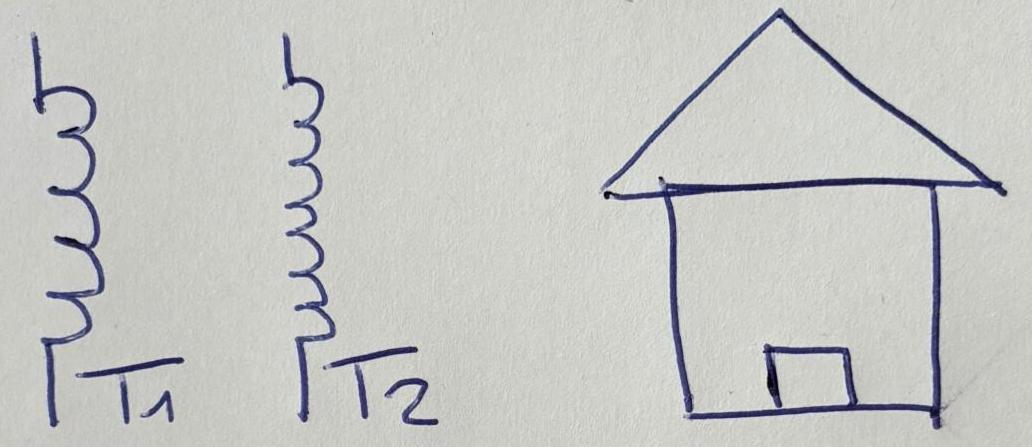

In [5]:
print(ocr_response.pages[0].images)

In [6]:
base64_image = ocr_response.pages[0].images[0].image_base64

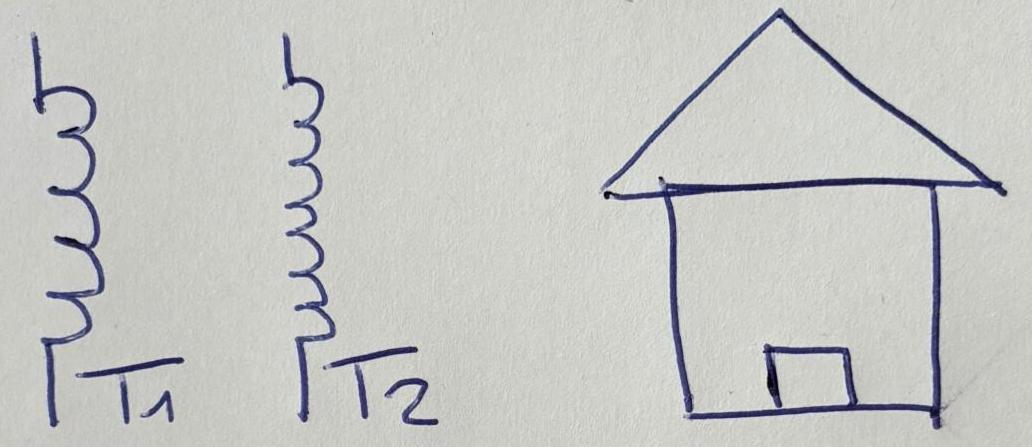

In [7]:
from IPython.display import display, Image
import base64

# Si tu as le préfixe, retire-le :
if base64_image.startswith("data:image"):
    base64_image = base64_image.split(",")[1]

# Correction du padding
missing_padding = len(base64_image) % 4
if missing_padding:
    base64_image += "=" * (4 - missing_padding)

display(Image(data=base64.b64decode(base64_image)))

## Test pour voir si ca marche avec des images de detecter des images

In [8]:
import os
from pydantic import BaseModel, Field
from mistralai import Mistral, DocumentURLChunk, ImageURLChunk, ResponseFormat
from mistralai.extra import response_format_from_pydantic_model
from dotenv import load_dotenv
import json

load_dotenv()

api_key = os.getenv("MISTRAL_API_KEY")
client = Mistral(api_key=api_key)



def image_transcription(base64_image: str) -> ResponseFormat:
    response = client.ocr.process(
      model="mistral-ocr-latest",
      document={
            "type": "image_url",
            "image_url": f"data:image/jpeg;base64,{base64_image}"
        },
      include_image_base64=True
    )
    return response

In [14]:
path = "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/IMG_3294.jpg"

In [15]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


In [16]:
image_base64 = encode_image(path)

In [17]:
ocr_response = image_transcription(image_base64)

In [18]:
print(len(ocr_response.pages[0].images))  # Nombre de pages détectées

4


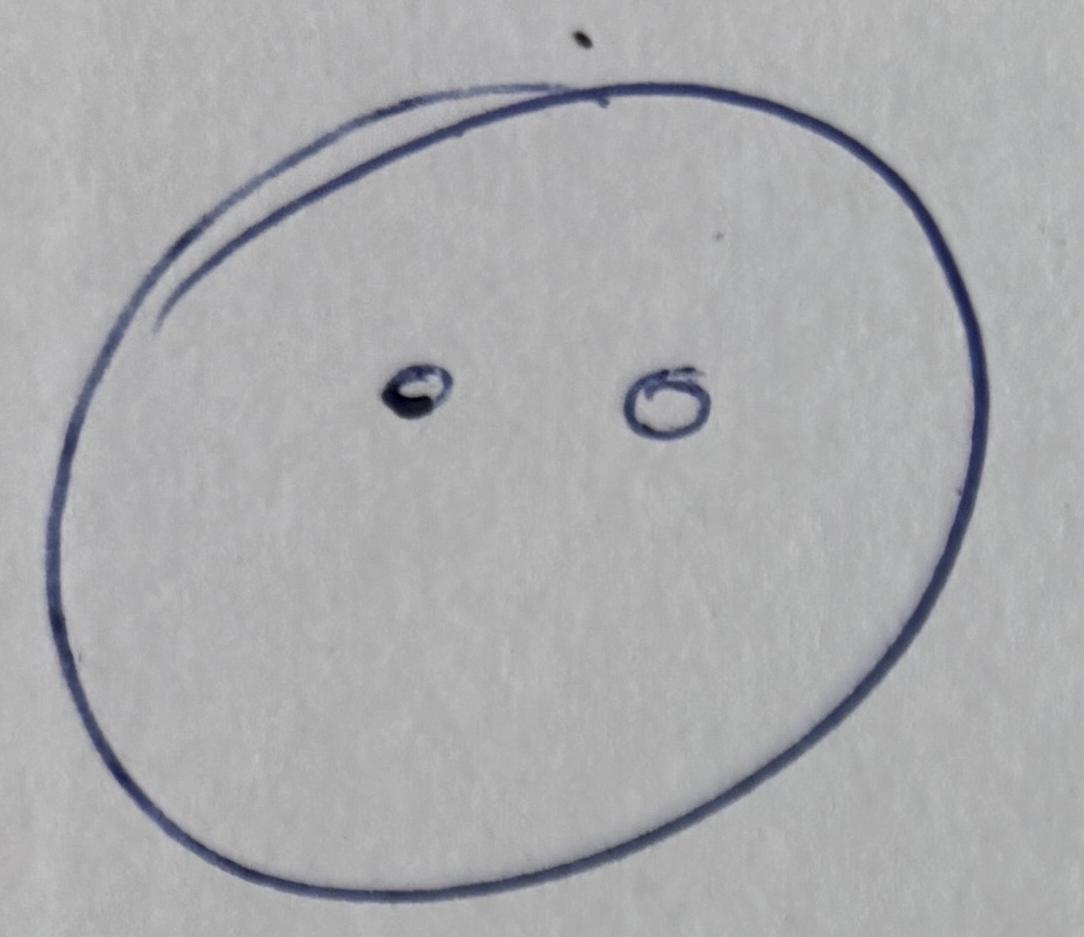

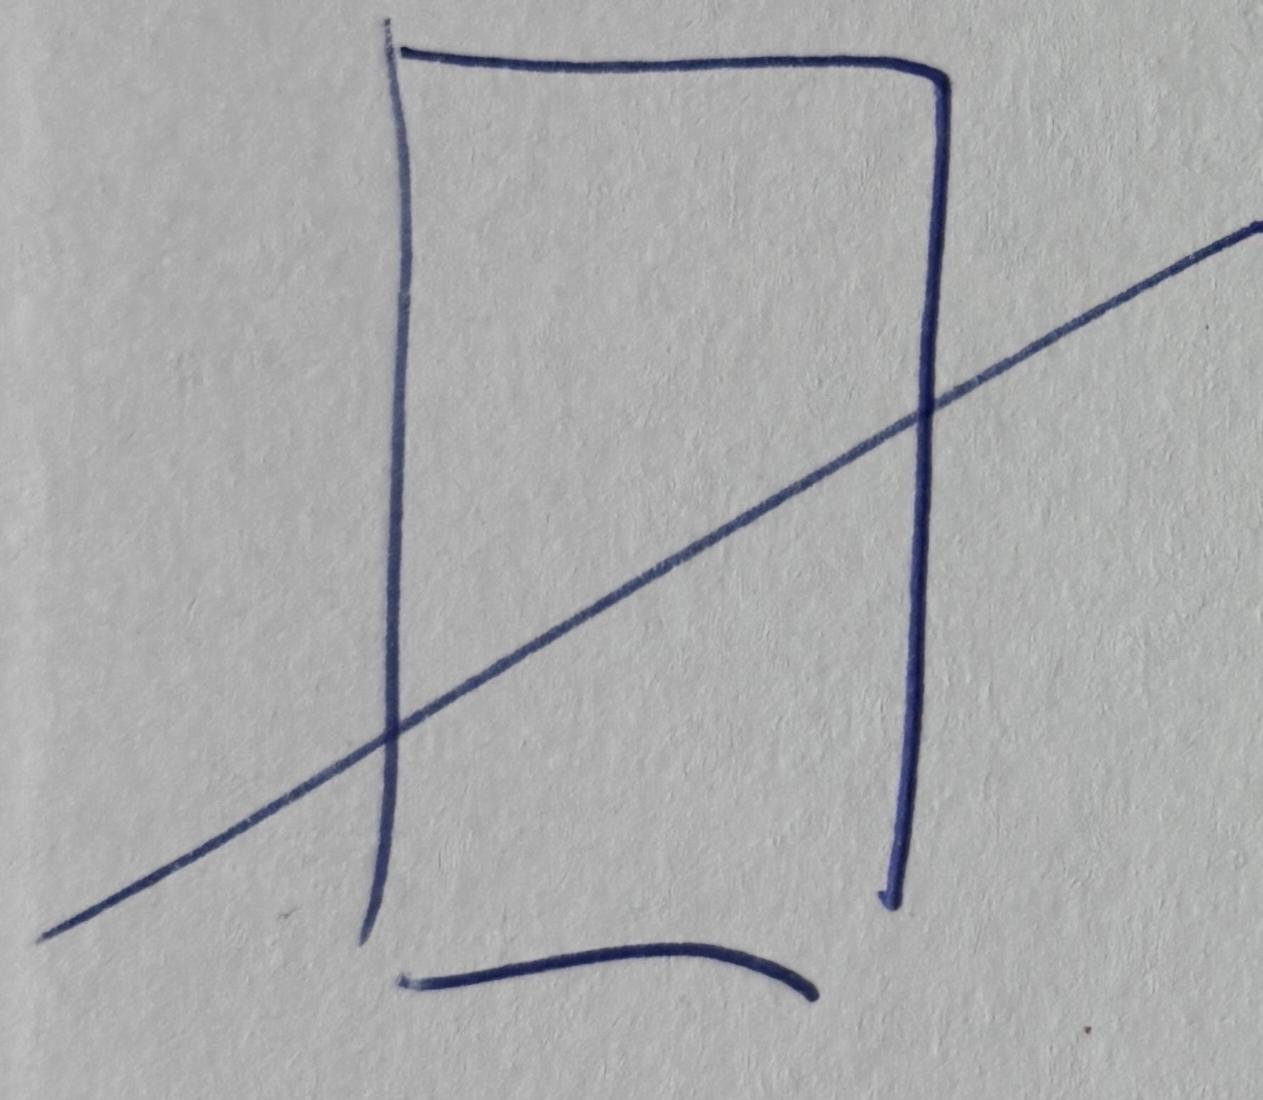

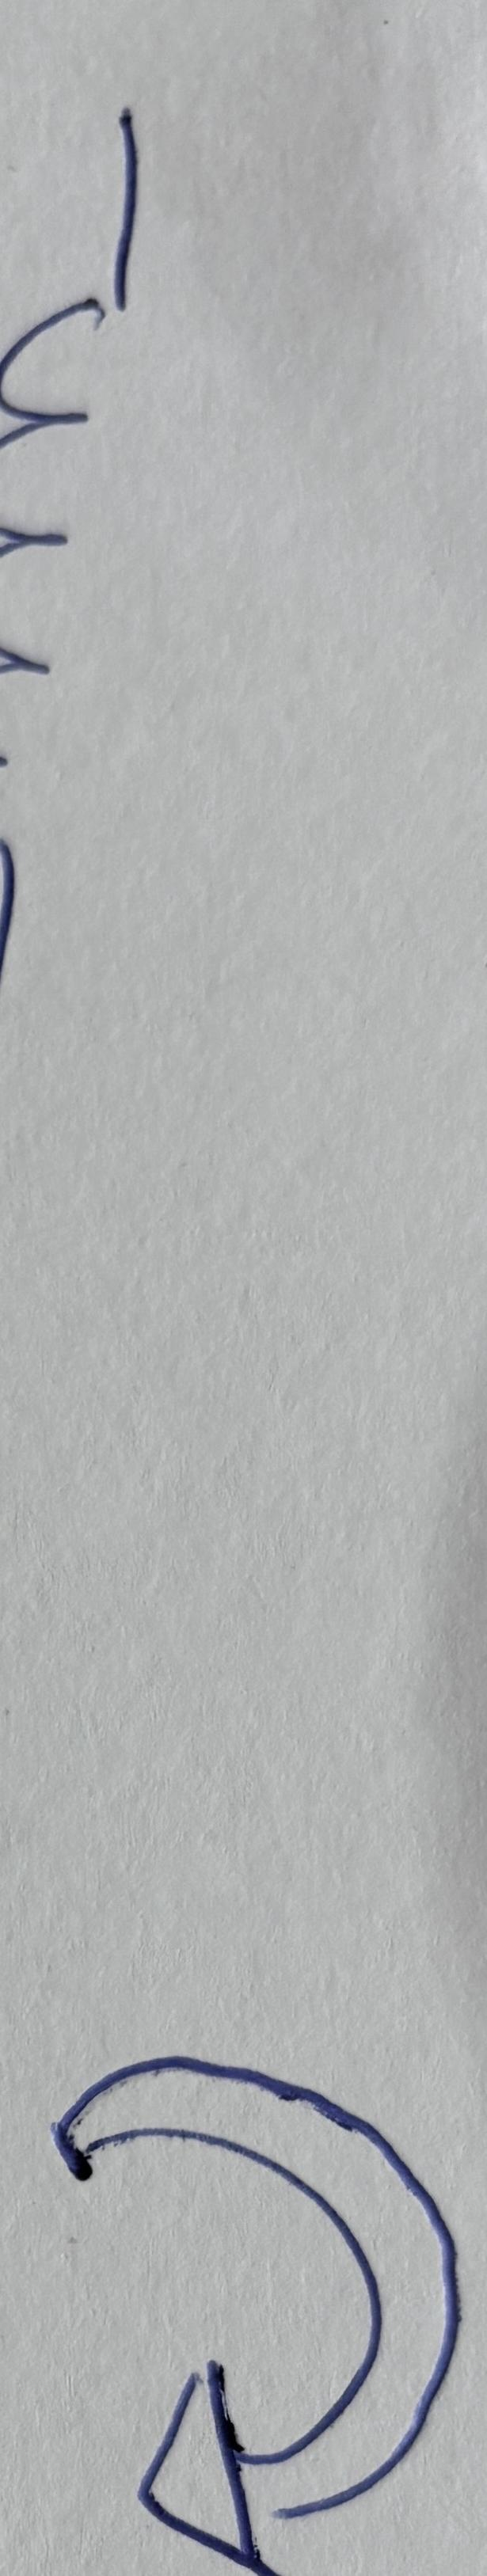

In [19]:
for i in range(3):
    base64_image = ocr_response.pages[0].images[i].image_base64

    from IPython.display import display, Image
    import base64

    # Si tu as le préfixe, retire-le :
    if base64_image.startswith("data:image"):
        base64_image = base64_image.split(",")[1]

    # Correction du padding
    missing_padding = len(base64_image) % 4
    if missing_padding:
        base64_image += "=" * (4 - missing_padding)

    display(Image(data=base64.b64decode(base64_image)))

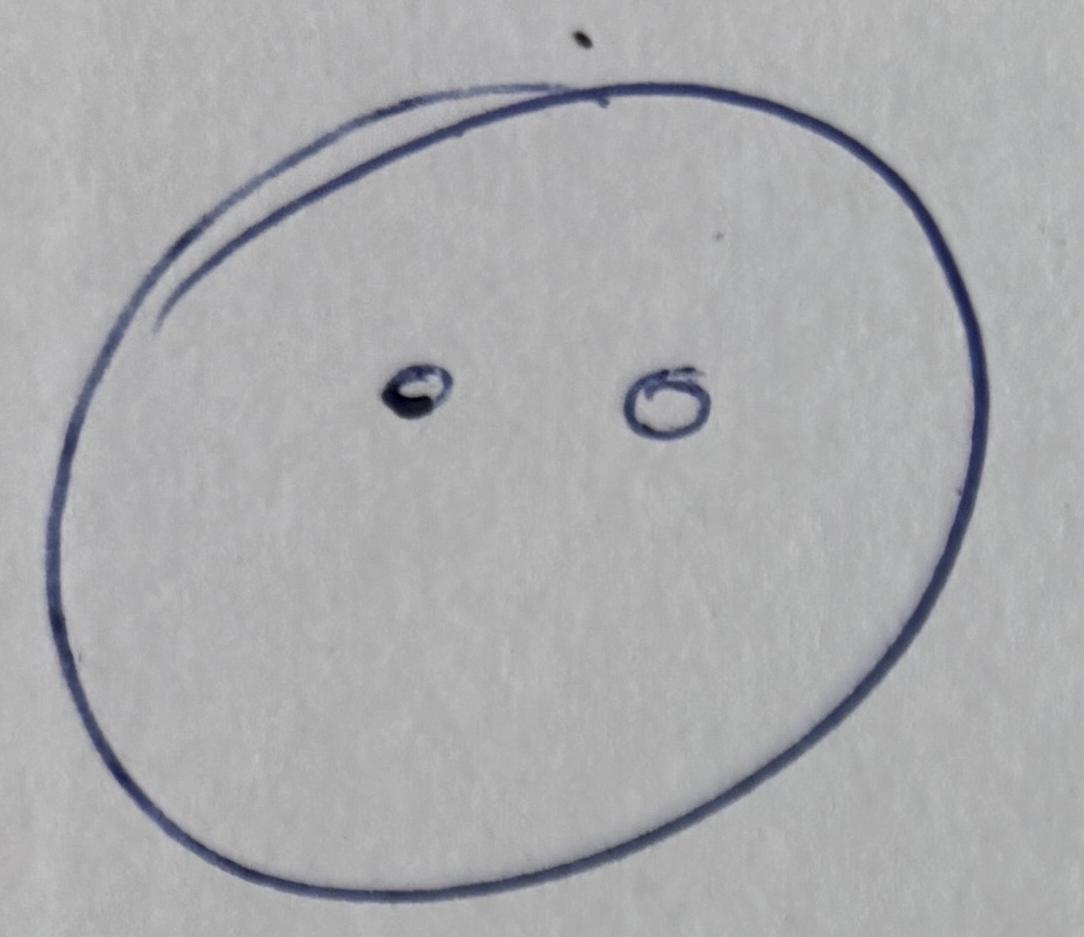

In [24]:
base64_image = ocr_response.pages[0].images[0].image_base64

from IPython.display import display, Image
import base64

# Si tu as le préfixe, retire-le :
if base64_image.startswith("data:image"):
    base64_image = base64_image.split(",")[1]

# Correction du padding
missing_padding = len(base64_image) % 4
if missing_padding:
    base64_image += "=" * (4 - missing_padding)

display(Image(data=base64.b64decode(base64_image)))

## Test modèle de vidion de Mistral

In [27]:
import base64
import requests
import os
from mistralai import Mistral

def encode_image(image_path):
    """Encode the image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {image_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None

# Path to your image
image_path = "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/zones_de_texte.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

api_key = os.getenv("MISTRAL_API_KEY")

# Specify model
model = "pixtral-12b-2409"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

# Define the messages for the chat
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "En combien de parties est séparée la note? et que contiennent chacune d'elles?"
            },
            {
                "type": "image_url",
                "image_url": f"data:image/jpeg;base64,{base64_image}" 
            }
        ]
    }
]

# Get the chat response
chat_response = client.chat.complete(
    model=model,
    messages=messages
)

# Print the content of the response
print(chat_response.choices[0].message.content)

La note est divisée en trois parties. La première partie concerne le changement de relais de 40 kV à 20 kV, avec des détails sur le secteur T4 et des contacts de rappel avec M. Martin. La deuxième partie contient des schémas étiquetés T1 et T2, et un croquis d'une petite structure. La troisième partie traite d'un appel passé avec Jean pour vérifier le planning des travaux et inclut une confirmation des travaux à partir du 8h, avec une note sur l'envoi d'un courrier CR à CM à 16h.


## Test détection zones de texte

In [5]:
import cv2, numpy as np, hashlib, os
from pathlib import Path

def binarize(gray):
    return cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 31, 10)

def find_diagram_regions(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    b = binarize(g)
    # contours externes
    cnts, _ = cv2.findContours(255-b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    H, W = g.shape[:2]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h < 0.01*W*H:  # éviter les poussières
            continue
        roi = g[y:y+h, x:x+w]
        # score "lignes" (dessin)
        edges = cv2.Canny(roi, 50, 150)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=40, minLineLength=int(0.2*min(w,h)), maxLineGap=10)
        n_lines = 0 if lines is None else len(lines)
        # OCR rapide sur ROI pour voir s'il y a du texte (optionnel si tesseract dispo)
        # text_len = len(tesseract(roi))  # pseudo
        text_len = 0
        # heuristique: beaucoup de lignes longues ET peu de texte => "dessin"
        if n_lines >= 3 and text_len < 8:
            candidates.append((x,y,w,h))
    return candidates

def save_crop(img, bbox, out_dir):
    x,y,w,h = bbox
    crop = img[y:y+h, x:x+w]
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    path = os.path.join(out_dir, f"diagram_{x}_{y}_{w}_{h}.jpg")
    cv2.imwrite(path, crop, [int(cv2.IMWRITE_JPEG_QUALITY), 92])
    hsh = hashlib.sha256(crop.tobytes()).hexdigest()[:16]
    return path, hsh

In [9]:

img = cv2.imread("/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/note_separees_schemas.jpg")
bboxes = find_diagram_regions(img)
for bb in bboxes: path, h = save_crop(img, bb, "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/test")


In [7]:
len(bboxes)

17

# Tentative de pipeline complète (détection de zones, 1 note = plusieurs sous_notes séparées par des traits, extraction des images)

## Détection des séparateurs et régions

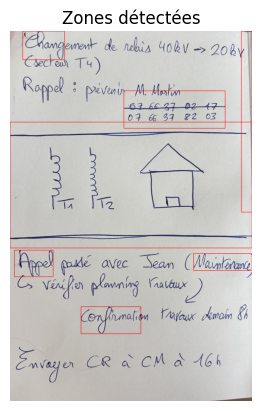

Zones détectées :
[0.05239179954441914, 0.0, 0.2255125284738041, 0.0775347912524851]
[0.9555808656036446, 0.0, 1.0, 0.4893141153081511]
[0.47038724373576307, 0.16153081510934394, 0.8887623386484435, 0.26267395626242546]
[0.0, 0.24602385685884692, 1.0, 0.5862326043737575]
[0.018223234624145785, 0.592196819085487, 0.1780561883067578, 0.6640159045725647]
[0.7585421412300684, 0.6011431411530815, 1.0, 0.6473658051689861]
[0.29309035687167806, 0.7450298210735586, 0.5406226271829917, 0.8180914512922465]


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def find_zones(image_path, min_area_ratio=0.01, debug=False):
    """
    Détecte les zones séparées par des traits ou espacements sur une note manuscrite.
    Retourne une liste de bounding boxes [x0, y0, x1, y1] normalisées (0..1).
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image non trouvée: {image_path}")
    
    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binarisation
    bin_img = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 31, 10
    )

    # Détection des lignes avec Hough
    edges = cv2.Canny(bin_img, 50, 150)
    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=60,
        minLineLength=W // 4,
        maxLineGap=20
    )

    mask_lines = np.zeros_like(bin_img)
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(mask_lines, (x1, y1), (x2, y2), 255, 5)

    # Suppression des lignes du contenu
    content = cv2.bitwise_and(bin_img, bin_img, mask=(mask_lines == 0).astype(np.uint8) * 255)

    # Regrouper en blocs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    merged = cv2.morphologyEx(content, cv2.MORPH_CLOSE, kernel, iterations=1)

    cnts, _ = cv2.findContours(merged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    zones = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < min_area_ratio * W * H:
            continue
        x0, y0, x1, y1 = x / W, y / H, (x + w) / W, (y + h) / H
        zones.append([x0, y0, x1, y1])

    # Trier haut -> bas
    zones.sort(key=lambda b: (b[1], b[0]))

    if debug:
        vis = img.copy()
        for (x0, y0, x1, y1) in zones:
            x0i, y0i, x1i, y1i = int(x0 * W), int(y0 * H), int(x1 * W), int(y1 * H)
            cv2.rectangle(vis, (x0i, y0i), (x1i, y1i), (0, 0, 255), 3)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title("Zones détectées")
        plt.axis("off")
        plt.show()

    return zones


if __name__ == "__main__":
    # Exemple : remplacer par ton chemin
    img_path = "/Users/tomamirault/Documents/Projects/p1-dty-rte/detection-notes/data/images/raw/zones_de_texte.jpg"
    zones = find_zones(img_path, debug=True)
    print("Zones détectées :")
    for z in zones:
        print(z)


In [30]:
def find_zones(image_path, min_area_ratio=0.01, debug=False):
    import matplotlib.pyplot as plt
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image non trouvée: {image_path}")

    H, W = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Binarisation
    bin_img = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 31, 10
    )
    if debug:
        plt.imshow(bin_img, cmap='gray')
        plt.title("Binarisation")
        plt.axis("off")
        plt.show()

    # 2. Détection des lignes avec Hough
    edges = cv2.Canny(bin_img, 50, 150)
    if debug:
        plt.imshow(edges, cmap='gray')
        plt.title("Canny edges")
        plt.axis("off")
        plt.show()

    lines = cv2.HoughLinesP(
        edges, 1, np.pi / 180,
        threshold=60,
        minLineLength=W // 4,
        maxLineGap=20
    )
    mask_lines = np.zeros_like(bin_img)
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(mask_lines, (x1, y1), (x2, y2), 255, 5)
    if debug:
        plt.imshow(mask_lines, cmap='gray')
        plt.title("Masque des lignes")
        plt.axis("off")
        plt.show()

    # 3. Suppression des lignes du contenu
    content = cv2.bitwise_and(bin_img, bin_img, mask=(mask_lines == 0).astype(np.uint8) * 255)
    if debug:
        plt.imshow(content, cmap='gray')
        plt.title("Sans lignes")
        plt.axis("off")
        plt.show()

    # 4. Regrouper en blocs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    merged = cv2.morphologyEx(content, cv2.MORPH_CLOSE, kernel, iterations=1)
    if debug:
        plt.imshow(merged, cmap='gray')
        plt.title("Blocs regroupés")
        plt.axis("off")
        plt.show()

    cnts, _ = cv2.findContours(merged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    zones = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w * h < min_area_ratio * W * H:
            continue
        x0, y0, x1, y1 = x / W, y / H, (x + w) / W, (y + h) / H
        zones.append([x0, y0, x1, y1])

    zones.sort(key=lambda b: (b[1], b[0]))

    if debug:
        vis = img.copy()
        for (x0, y0, x1, y1) in zones:
            x0i, y0i, x1i, y1i = int(x0 * W), int(y0 * H), int(x1 * W), int(y1 * H)
            cv2.rectangle(vis, (x0i, y0i), (x1i, y1i), (0, 0, 255), 3)
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title("Zones détectées")
        plt.axis("off")
        plt.show()

    return zones

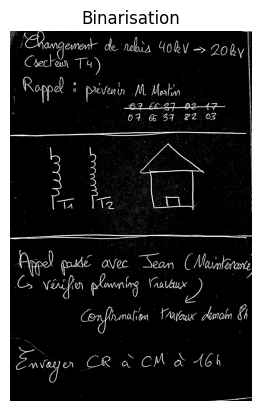

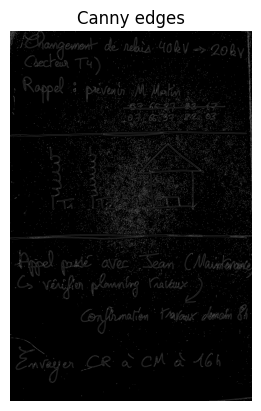

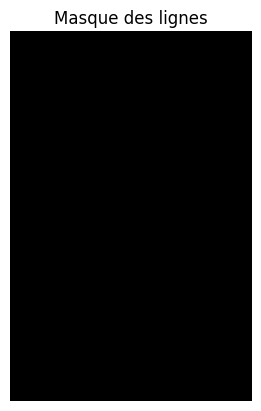

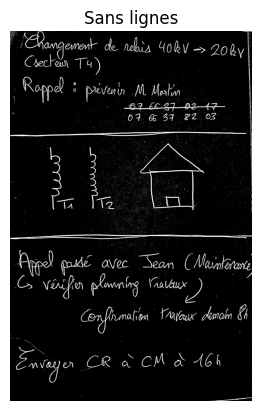

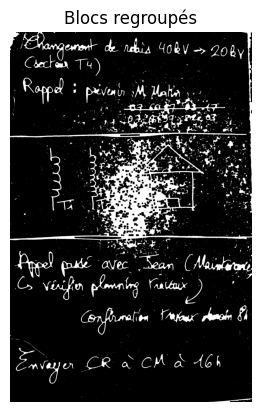

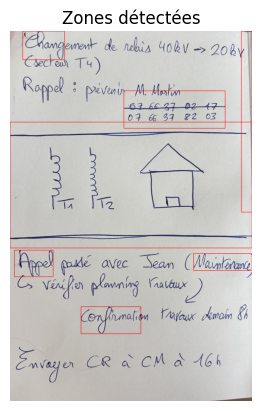

In [31]:
zones = find_zones(img_path, debug=True)